In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding as LLE, MDS
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from scipy.spatial import procrustes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from PIL import Image
from sklearn.metrics import silhouette_score


In [4]:
folder_path = '/content/drive/MyDrive/AI_ML_3/360 Rocks'
image_size = (100, 100)

# Load images and labels
images, labels = [], []
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img = Image.open(os.path.join(folder_path, filename)).convert('L')
        img = img.resize(image_size)
        images.append(np.array(img).flatten())
        labels.append(filename[0])

images = np.array(images)
labels = np.array(labels)
print(images.shape)
print(labels.shape)

(360, 10000)
(360,)


In [5]:
pca_90 = PCA(n_components=0.90)
images_pca = pca_90.fit_transform(images)

print(f"Number of components to preserve 90% variance: {pca_90.n_components_}")


Number of components to preserve 90% variance: 112


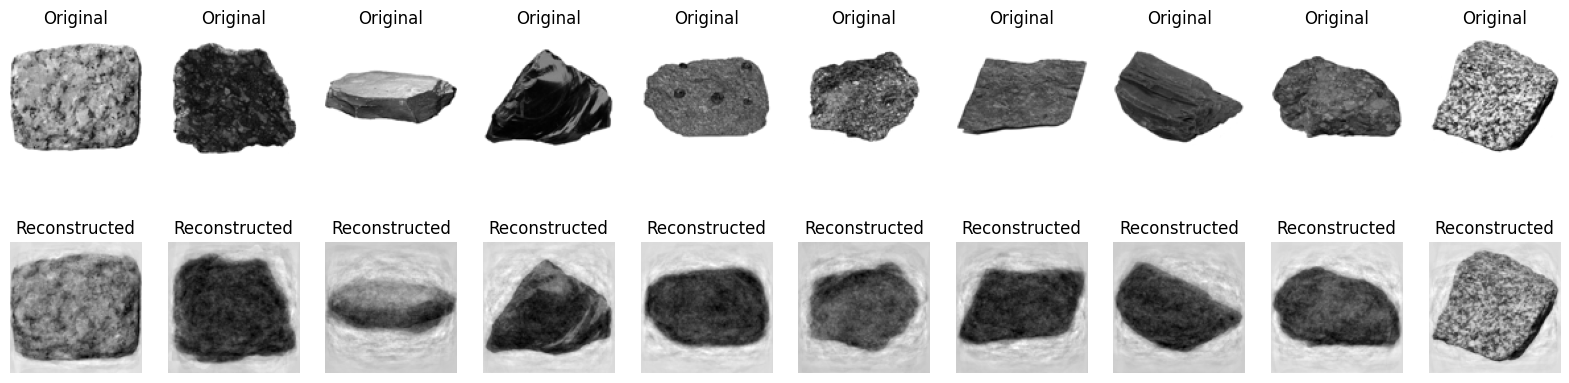

In [6]:
# Reconstruct images
reconstructed_images = pca_90.inverse_transform(images_pca)

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(20, 5))
for i in range(10):
    axes[0, i].imshow(images[i].reshape(image_size), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_images[i].reshape(image_size), cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')
plt.show()

Variance explained by 2 components: 0.37


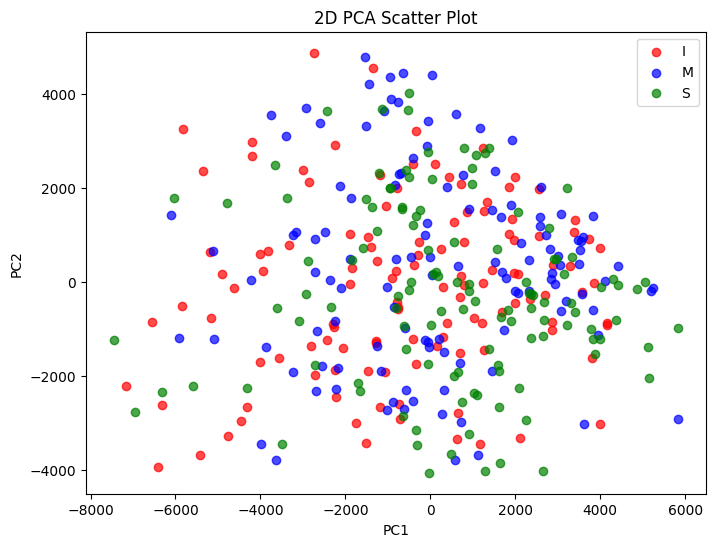

In [7]:
pca_2 = PCA(n_components=2)
images_pca_2 = pca_2.fit_transform(images)
variance_2 = np.sum(pca_2.explained_variance_ratio_)

print(f"Variance explained by 2 components: {variance_2:.2f}")

# Scatter plot with categories
categories = ['I', 'M', 'S']
colors = {'I': 'red', 'M': 'blue', 'S': 'green'}

plt.figure(figsize=(8, 6))
for category in categories:
    indices = labels == category
    plt.scatter(images_pca_2[indices, 0], images_pca_2[indices, 1], c=colors[category], label=category, alpha=0.7)
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Scatter Plot")
plt.show()

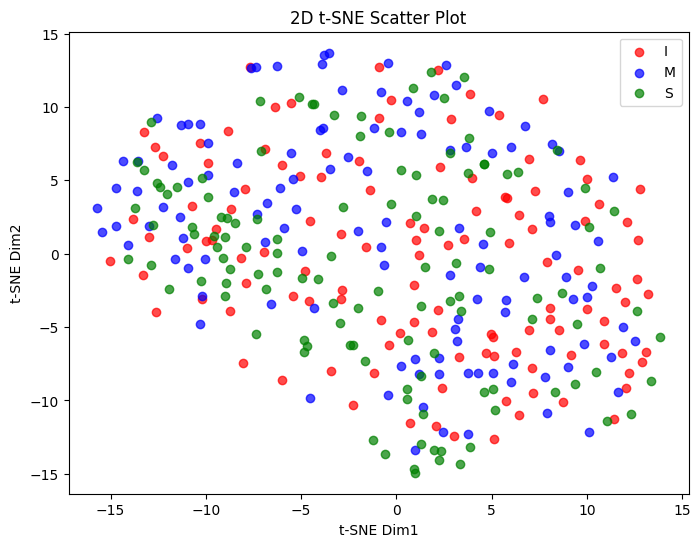

In [8]:
tsne = TSNE(n_components=2, random_state=25)
images_tsne = tsne.fit_transform(images)

plt.figure(figsize=(8, 6))
for category in categories:
    indices = labels == category
    plt.scatter(images_tsne[indices, 0], images_tsne[indices, 1], c=colors[category], label=category, alpha=0.7)
plt.legend()
plt.xlabel("t-SNE Dim1")
plt.ylabel("t-SNE Dim2")
plt.title("2D t-SNE Scatter Plot")
plt.show()


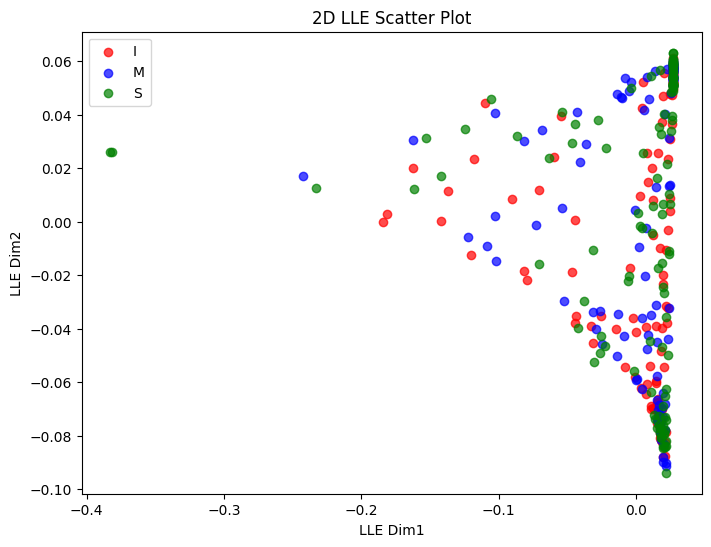

In [9]:
lle = LLE(n_components=2, random_state=25)
images_lle = lle.fit_transform(images)

plt.figure(figsize=(8, 6))
for category in categories:
    indices = labels == category
    plt.scatter(images_lle[indices, 0], images_lle[indices, 1], c=colors[category], label=category, alpha=0.7)
plt.legend()
plt.xlabel("LLE Dim1")
plt.ylabel("LLE Dim2")
plt.title("2D LLE Scatter Plot")
plt.show()

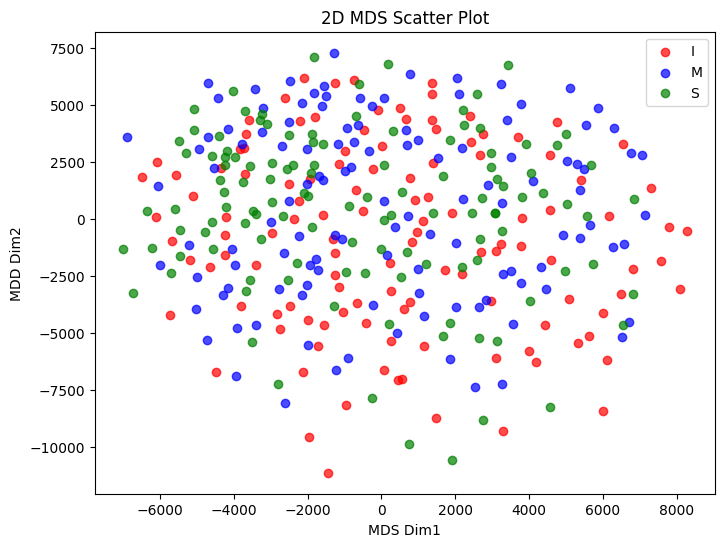

In [10]:
mds = MDS(n_components=2, random_state=25)
images_mds = mds.fit_transform(images)

plt.figure(figsize=(8, 6))
for category in categories:
    indices = labels == category
    plt.scatter(images_mds[indices, 0], images_mds[indices, 1], c=colors[category], label=category, alpha=0.7)
plt.legend()
plt.xlabel("MDS Dim1")
plt.ylabel("MDD Dim2")
plt.title("2D MDS Scatter Plot")
plt.show()

In [11]:
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Set the directory path to the '360 Rocks' folder
images_folder = '/content/drive/MyDrive/AI_ML_3/360 Rocks'

# Initialize lists to store data
original_images = []  # This will store the raw images
flat_images = []      # This will store the flattened images
labels = []           # This will store the category labels

# Function to load and preprocess images
def load_images_from_folder(folder_path):
    for filename in os.listdir(folder_path):
        # Build the complete path to the image file
        img_path = os.path.join(folder_path, filename)

        try:
            # Load the image
            with Image.open(img_path) as img:
                # Convert to grayscale
                img = img.convert("L")

                # Resize if necessary (you can adjust based on memory limitations)
                img = img.resize((128, 128))  # Resize to 128x128 for consistency (adjust if needed)

                # Save the raw image
                original_images.append(np.array(img))

                # Flatten the image and store it
                flat_images.append(np.array(img).flatten())

                # Extract the label from the filename's first letter
                label = filename[0]  # Assuming 'I', 'M', 'S' indicate categories
                labels.append(label)

        except Exception as e:
            print(f"Error processing file {filename}: {e}")

# Load images
load_images_from_folder(images_folder)


# Convert lists to numpy arrays
images = np.array(images)
original_images = np.array(original_images)

# Encode labels to numeric values for easier processing
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Output dimensions for verification
print(f"Loaded {len(original_images)} images.")
print(f"Flattened image shape: {images.shape}")
print(f"Unique labels: {label_encoder.classes_}")


Loaded 360 images.
Flattened image shape: (360, 10000)
Unique labels: ['I' 'M' 'S']


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image
from matplotlib import offsetbox

# Function to plot 2D scatter plot with image thumbnails
def plot_2d_images(embedded_data, images, labels, title, method_name, thumb_size=(25, 25)):
    plt.figure(figsize=(20, 15))
    ax = plt.gca()

    # Scatter plot to create colored points based on categories
    categories = ['I', 'M', 'S']
    colors = ['red', 'blue', 'green']

    # Plot points first for colors
    for idx, category in enumerate(categories):
        category_indices = [i for i, label in enumerate(labels) if label.startswith(category)]
        plt.scatter(
            embedded_data[category_indices, 0],
            embedded_data[category_indices, 1],
            c=colors[idx],
            label=category,
            alpha=1
        )

    # Adding image thumbnails at points
    for (x, y), img in zip(embedded_data, images):
        img = Image.fromarray(img).convert("L")  # Convert to grayscale
        img.thumbnail(thumb_size, Image.Resampling.LANCZOS)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(img, cmap='gray'),
            (x, y),
            frameon=True
        )
        ax.add_artist(imagebox)

    plt.title(f"{method_name} - {title}")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

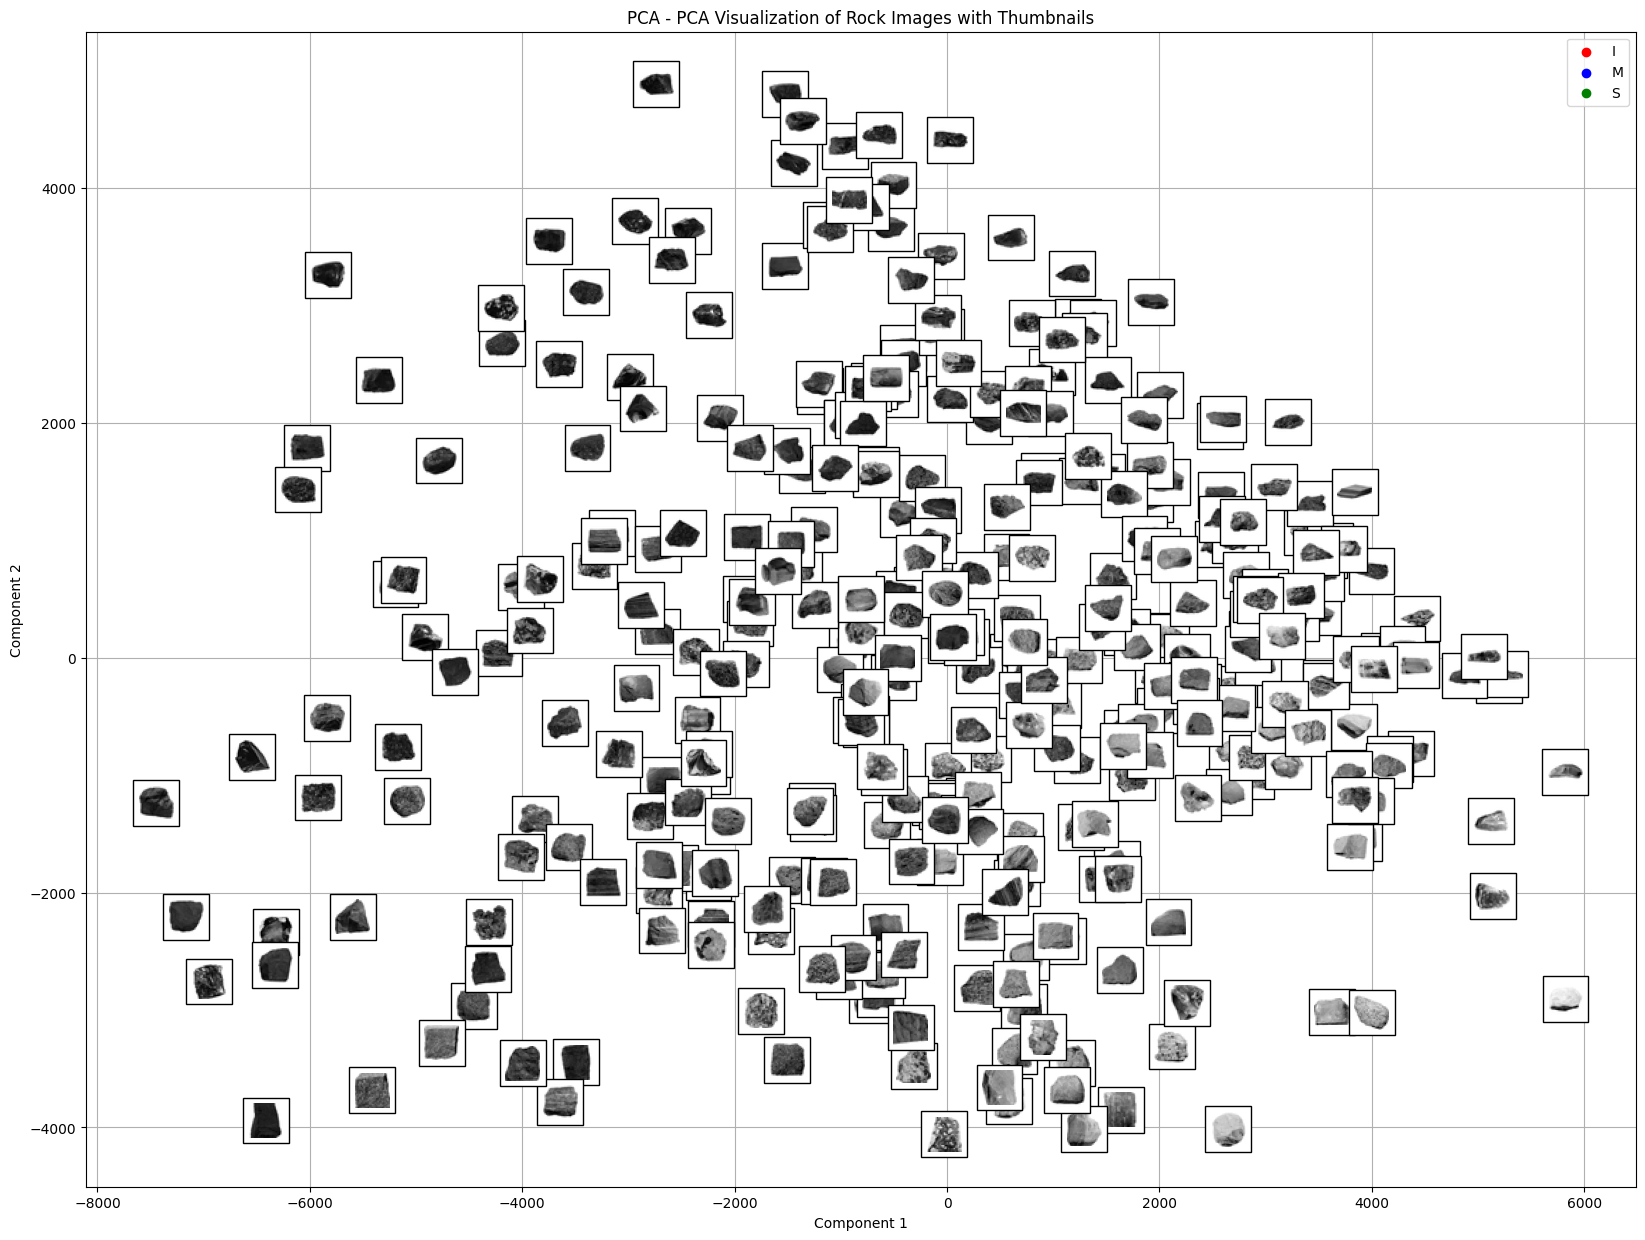

In [13]:
pca_2 = PCA(n_components=2 , random_state=42)
pca_2d = pca_2.fit_transform(images)

plot_2d_images(pca_2d, original_images, labels, "PCA Visualization of Rock Images with Thumbnails", "PCA")

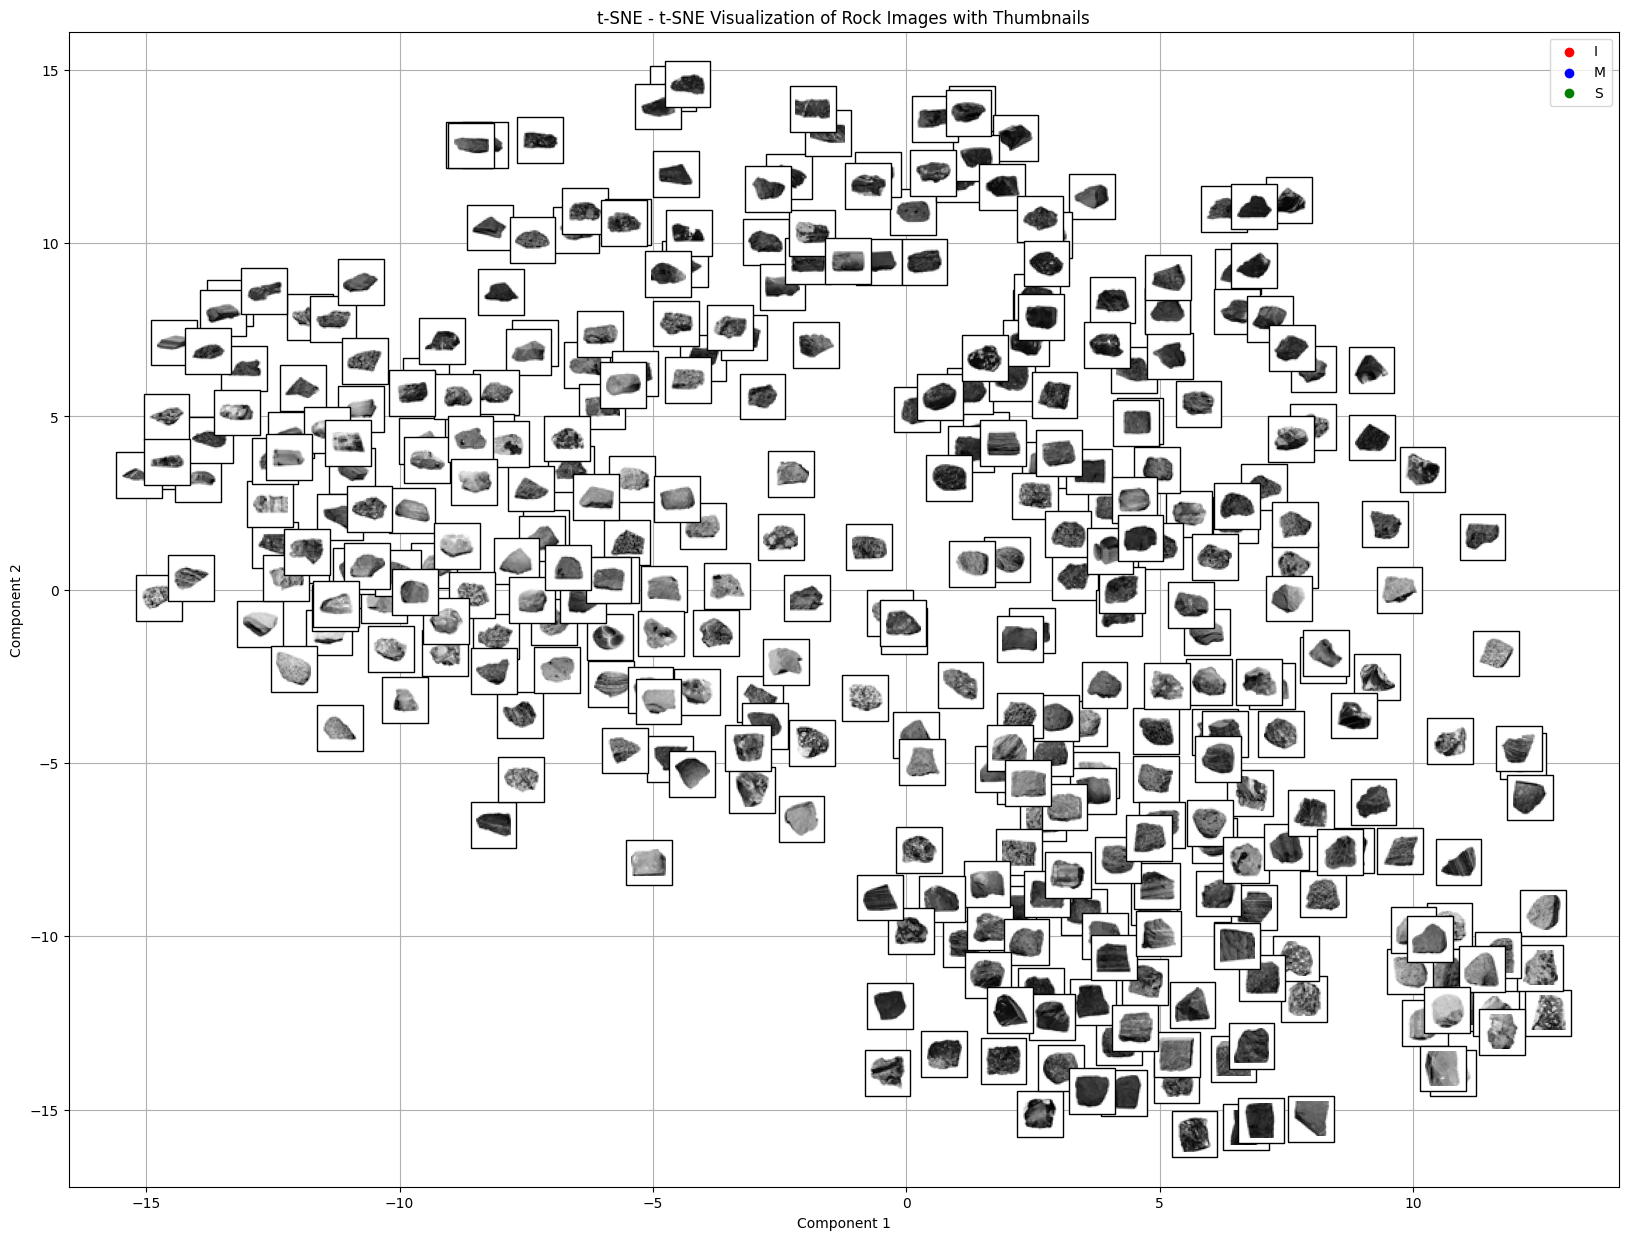

In [14]:
# Assuming `flat_images` (flattened 2D image data) and `original_images` (list of raw image arrays) are ready
# Assuming `labels` are the rock categories
# Run dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_2d = tsne.fit_transform(images)

# Plot images using the enhanced plot function
plot_2d_images(tsne_2d, original_images, labels, "t-SNE Visualization of Rock Images with Thumbnails", "t-SNE")

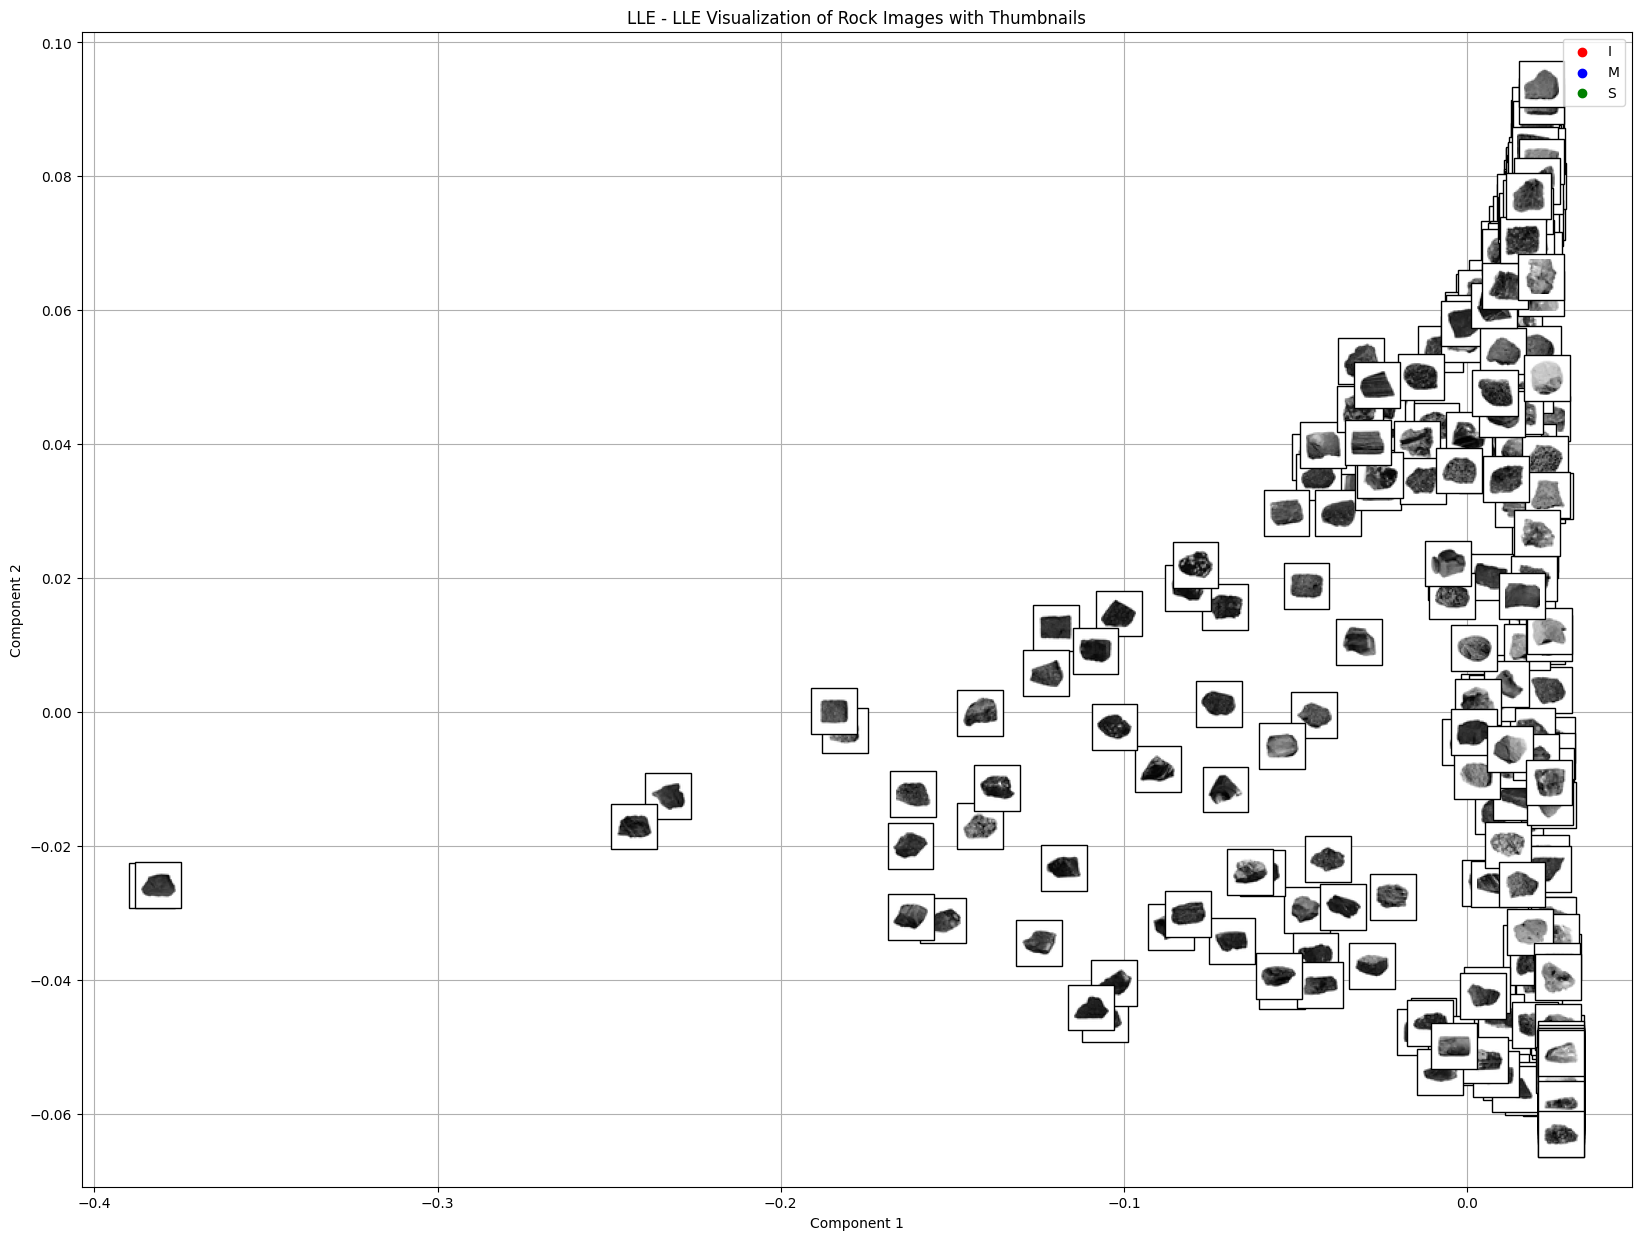

In [15]:
lle = LLE(n_components=2 )
reduced_lle = lle.fit_transform(images)

plot_2d_images(reduced_lle, original_images, labels, "LLE Visualization of Rock Images with Thumbnails", "LLE")

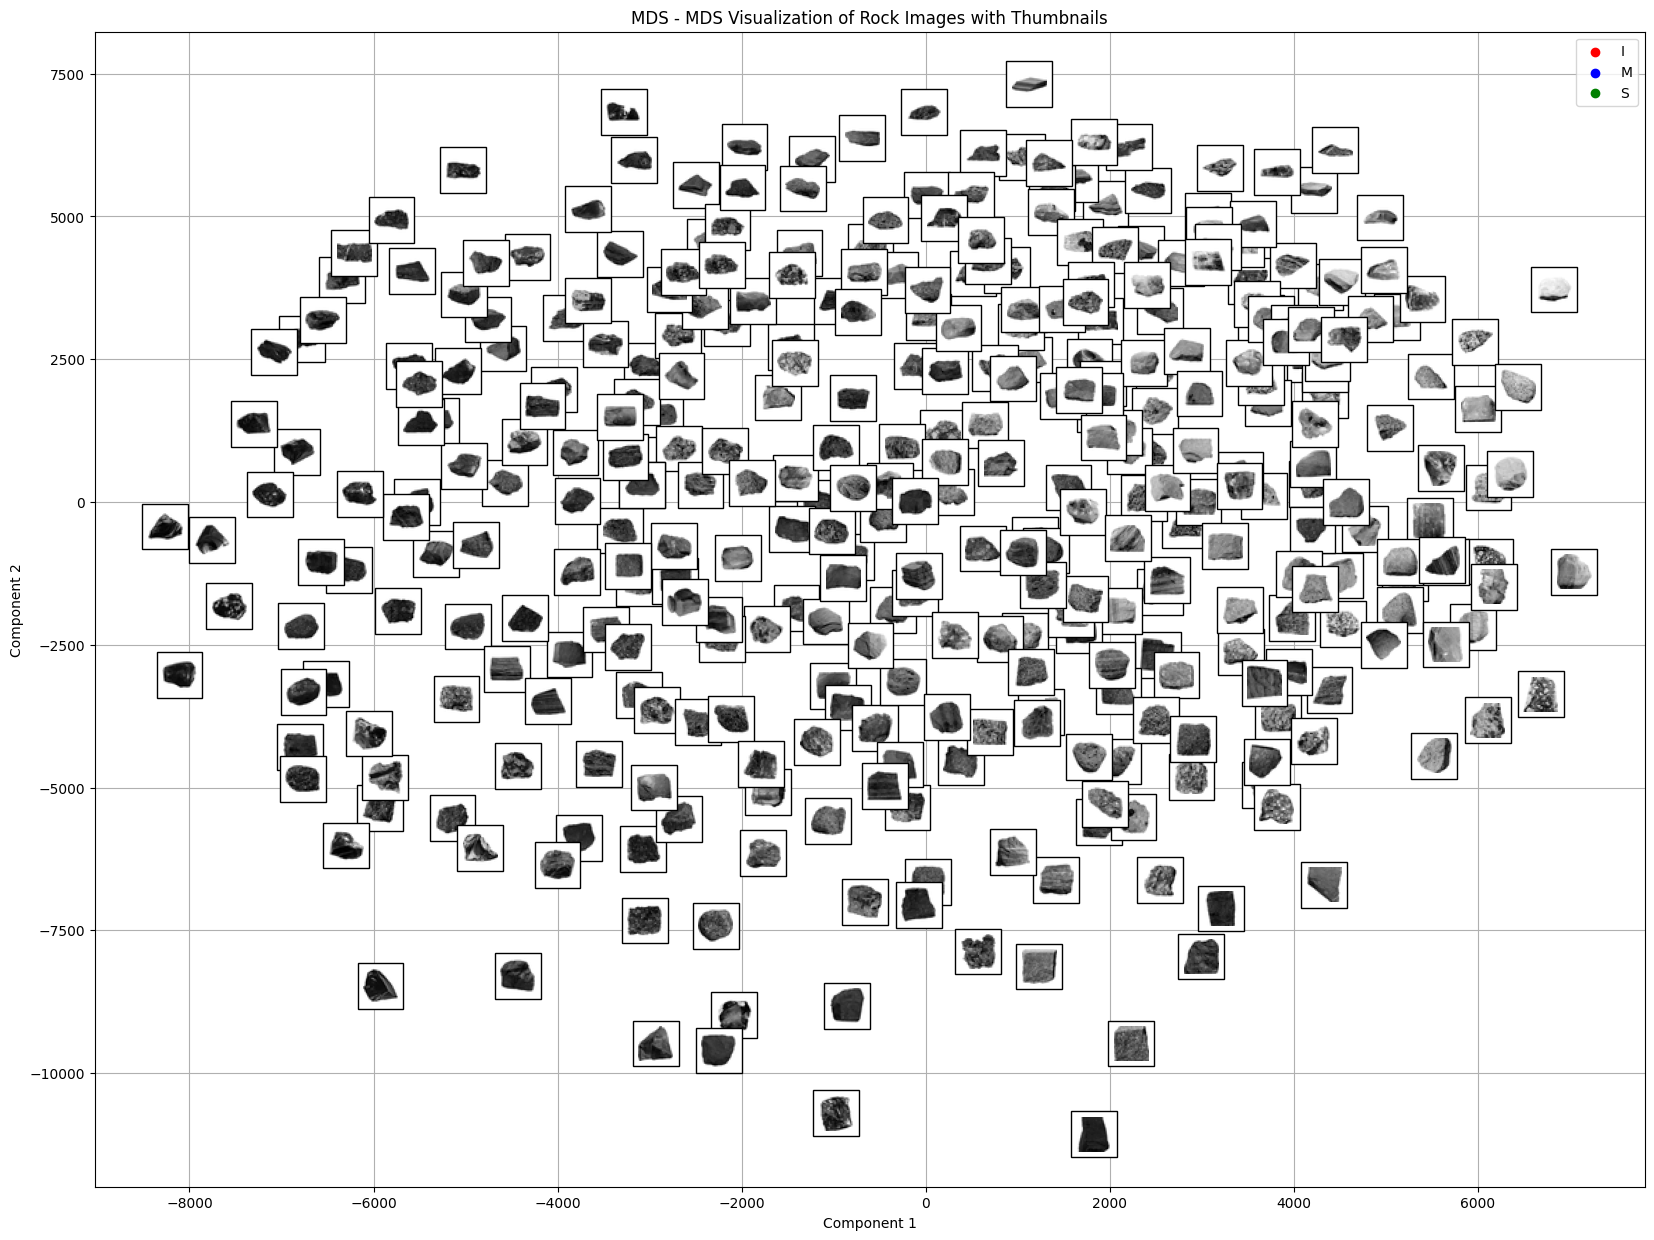

In [16]:
mds = MDS(n_components=2, random_state=42)

reduced_mds = mds.fit_transform(images)

plot_2d_images(reduced_mds, original_images, labels, "MDS Visualization of Rock Images with Thumbnails", "MDS")

In [ ]:
pca_8 = PCA(n_components=8)
images_pca_8 = pca_8.fit_transform(images)

In [ ]:
lle_8 = LLE(n_components=8, random_state=25)
images_lle_8 = lle_8.fit_transform(images)

In [ ]:
mds_8 = MDS(n_components=8, random_state=25)
images_mds_8 = mds_8.fit_transform(images)

In [ ]:
# Load human data
human_data = np.loadtxt('/content/drive/MyDrive/AI_ML_3/360 Rocks/mds_360.txt')
# Compare PCA embeddings with human data
mtx1_pca, mtx2_pca, disparity_pca = procrustes(human_data, images_pca_8)
print(f"Disparity for PCA: {disparity_pca}")

# Compare LLE embeddings with human data
mtx1_lle, mtx2_lle, disparity_lle = procrustes(human_data, images_lle_8)
print(f"Disparity for LLE: {disparity_lle}")

# Compare MDS embeddings with human data
mtx1_mds, mtx2_mds, disparity_mds = procrustes(human_data,images_mds_8)
print(f"Disparity for MDS: {disparity_mds}")

Disparity for PCA: 0.9835404541820771
Disparity for LLE: 0.985716949627002
Disparity for MDS: 0.9816363162075624


In [ ]:
def compute_correlation(mtx1, mtx2):
    correlations = []
    for i in range(mtx1.shape[1]):
        corr = np.corrcoef(mtx1[:, i], mtx2[:, i])[0, 1]
        correlations.append(corr)
    return correlations


correlation_pca = compute_correlation(mtx1_pca, mtx2_pca)
correlation_lle = compute_correlation(mtx1_lle, mtx2_lle)
correlation_mds = compute_correlation(mtx1_mds, mtx2_mds)
res = pd.DataFrame({
    "PCA": correlation_pca,
    "LLE": correlation_lle,
    "MDS": correlation_mds
}, index=[f"Dimension {i+1}" for i in range(8)])

print(res)

                  PCA       LLE       MDS
Dimension 1  0.125320  0.099072  0.114899
Dimension 2  0.071957  0.102094  0.090431
Dimension 3  0.120840  0.125141  0.134851
Dimension 4  0.172916  0.120006  0.172454
Dimension 5  0.112456  0.174022  0.143209
Dimension 6  0.147673  0.172669  0.155001
Dimension 7  0.159041  0.118224  0.166571
Dimension 8  0.122163  0.040970  0.112146


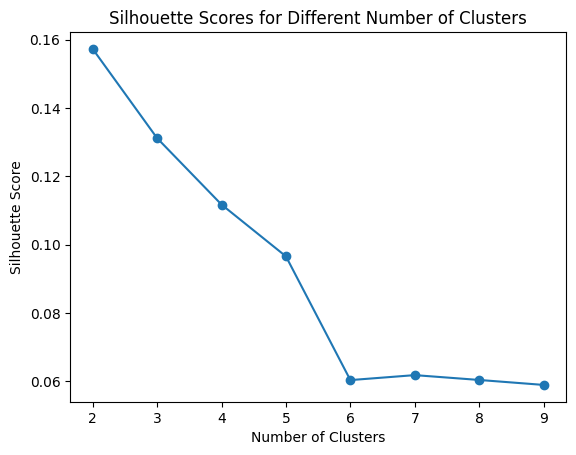

Optimal number of clusters: 2


In [ ]:
silhouette_scores = []
range_clusters = range(2, 10)  # Evaluate cluster sizes from 2 to 10

for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(images_pca)
    score = silhouette_score(images_pca, cluster_labels)
    silhouette_scores.append(score)

# Plot silhouette scores
import matplotlib.pyplot as plt

plt.plot(range_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

# Select the number of clusters with the highest silhouette score
optimal_clusters = range_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters: {optimal_clusters}")

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=25)
cluster_labels = kmeans.fit_predict(images_pca)
print(f"Cluster labels: {cluster_labels}")

Cluster labels: [0 1 1 1 1 1 2 0 1 2 2 1 0 0 2 2 2 1 2 1 1 0 1 2 1 0 1 2 2 1 1 1 1 0 0 2 0
 1 1 0 0 0 1 0 2 0 1 1 0 2 2 1 0 0 0 0 0 0 2 2 0 1 2 0 1 0 2 2 0 2 2 0 2 0
 2 0 0 0 0 1 2 2 1 0 1 1 0 2 1 2 2 0 1 1 2 0 1 0 0 2 2 1 2 2 2 2 0 0 0 2 0
 2 2 1 1 1 1 0 1 1 2 0 0 0 2 2 2 1 0 2 2 1 2 0 0 1 1 2 1 1 2 2 1 1 1 1 1 1
 1 1 2 0 0 0 0 0 0 0 0 0 1 2 1 2 1 1 1 1 1 1 2 0 1 1 2 0 0 0 1 0 2 0 0 2 2
 1 1 2 0 0 2 2 0 0 0 2 1 0 0 0 2 1 1 1 1 1 2 1 2 0 1 0 2 0 1 1 0 0 2 1 0 2
 2 2 0 0 0 0 1 0 1 2 2 0 2 0 1 0 0 2 0 2 1 0 0 2 0 2 0 1 1 1 0 0 1 0 0 0 0
 2 1 0 0 0 0 0 2 0 1 0 2 0 0 1 2 2 0 1 0 0 2 2 1 0 0 0 0 2 0 0 0 0 0 0 0 0
 2 2 0 0 0 0 0 0 0 0 1 0 0 1 2 1 0 0 1 1 0 1 0 0 0 0 2 0 1 0 2 1 2 1 1 2 2
 0 2 2 0 2 0 1 0 0 0 0 0 0 1 1 0 0 1 2 1 0 1 2 1 2 2 2]


In [ ]:
from sklearn.metrics import accuracy_score
from collections import Counter

# Map cluster labels to true labels (I, M, S)
true_labels = []
file_names=os.listdir(folder_path) # Extract the true labels from file names, e.g., based on the first letter
for filename in file_names:  # Replace `file_names` with your list of image filenames
  if filename.endswith('.jpg') or filename.endswith('.png'):
    if filename.startswith('I'):
        true_labels.append(0)
    elif filename.startswith('M'):
        true_labels.append(1)
    elif filename.startswith('S'):
        true_labels.append(2)

# Relabel clusters to match true labels
cluster_to_true_mapping = {}
for cluster in set(cluster_labels):
    most_common_label = Counter(true_labels[i] for i in range(len(cluster_labels)) if cluster_labels[i] == cluster).most_common(1)[0][0]
    cluster_to_true_mapping[cluster] = most_common_label

mapped_cluster_labels = [cluster_to_true_mapping[label] for label in cluster_labels]

# Compute accuracy
accuracy = accuracy_score(true_labels, mapped_cluster_labels)
print(f"Clustering accuracy with 3 clusters: {accuracy:.2f}")


Clustering accuracy with 3 clusters: 0.39


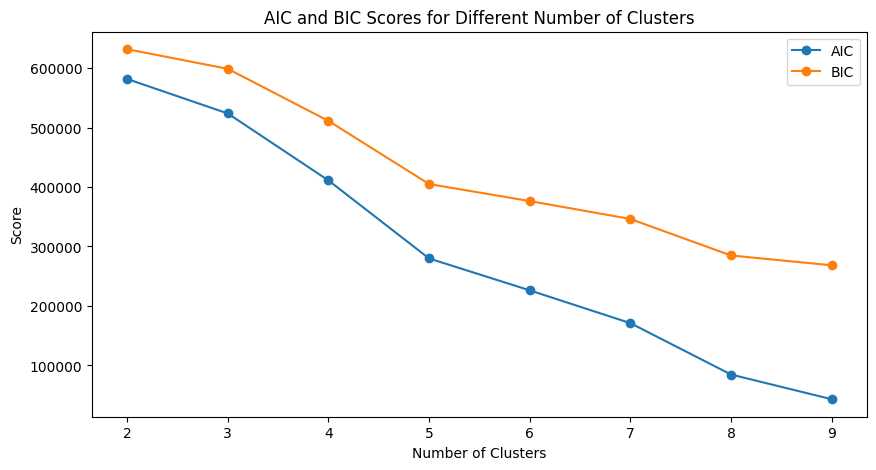

Optimal clusters based on AIC: 9
Optimal clusters based on BIC: 9


In [ ]:
from sklearn.mixture import GaussianMixture

aic_scores = []
bic_scores = []
range_clusters = range(2, 10)

for n_clusters in range_clusters:
    gmm = GaussianMixture(n_components=n_clusters, random_state=25)
    gmm.fit(images_pca)
    aic_scores.append(gmm.aic(images_pca))
    bic_scores.append(gmm.bic(images_pca))

# Plot AIC and BIC scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range_clusters, aic_scores, label='AIC', marker='o')
plt.plot(range_clusters, bic_scores, label='BIC', marker='o')
plt.title("AIC and BIC Scores for Different Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.show()

# Select the number of clusters with the lowest BIC or AIC
optimal_clusters_aic = range_clusters[aic_scores.index(min(aic_scores))]
optimal_clusters_bic = range_clusters[bic_scores.index(min(bic_scores))]
print(f"Optimal clusters based on AIC: {optimal_clusters_aic}")
print(f"Optimal clusters based on BIC: {optimal_clusters_bic}")


In [ ]:
# GMM with 3 clusters
gmm = GaussianMixture(n_components=3, random_state=25)
cluster_labels_gmm = gmm.fit_predict(images_pca)
print(f"Cluster labels: {cluster_labels}")


Cluster labels: [0 1 1 1 1 1 2 0 1 2 2 1 0 0 2 2 2 1 2 1 1 0 1 2 1 0 1 2 2 1 1 1 1 0 0 2 0
 1 1 0 0 0 1 0 2 0 1 1 0 2 2 1 0 0 0 0 0 0 2 2 0 1 2 0 1 0 2 2 0 2 2 0 2 0
 2 0 0 0 0 1 2 2 1 0 1 1 0 2 1 2 2 0 1 1 2 0 1 0 0 2 2 1 2 2 2 2 0 0 0 2 0
 2 2 1 1 1 1 0 1 1 2 0 0 0 2 2 2 1 0 2 2 1 2 0 0 1 1 2 1 1 2 2 1 1 1 1 1 1
 1 1 2 0 0 0 0 0 0 0 0 0 1 2 1 2 1 1 1 1 1 1 2 0 1 1 2 0 0 0 1 0 2 0 0 2 2
 1 1 2 0 0 2 2 0 0 0 2 1 0 0 0 2 1 1 1 1 1 2 1 2 0 1 0 2 0 1 1 0 0 2 1 0 2
 2 2 0 0 0 0 1 0 1 2 2 0 2 0 1 0 0 2 0 2 1 0 0 2 0 2 0 1 1 1 0 0 1 0 0 0 0
 2 1 0 0 0 0 0 2 0 1 0 2 0 0 1 2 2 0 1 0 0 2 2 1 0 0 0 0 2 0 0 0 0 0 0 0 0
 2 2 0 0 0 0 0 0 0 0 1 0 0 1 2 1 0 0 1 1 0 1 0 0 0 0 2 0 1 0 2 1 2 1 1 2 2
 0 2 2 0 2 0 1 0 0 0 0 0 0 1 1 0 0 1 2 1 0 1 2 1 2 2 2]


In [ ]:
from sklearn.metrics import accuracy_score
from collections import Counter

# Map cluster labels to true labels (I, M, S)
true_labels = []
file_names=os.listdir(folder_path) # Extract the true labels from file names, e.g., based on the first letter
for filename in file_names:  # Replace `file_names` with your list of image filenames
  if filename.endswith('.jpg') or filename.endswith('.png'):
    if filename.startswith('I'):
        true_labels.append(0)
    elif filename.startswith('M'):
        true_labels.append(1)
    elif filename.startswith('S'):
        true_labels.append(2)

# Relabel clusters to match true labels
cluster_to_true_mapping = {}
for cluster in set(cluster_labels_gmm):
    most_common_label = Counter(true_labels[i] for i in range(len(cluster_labels)) if cluster_labels[i] == cluster).most_common(1)[0][0]
    cluster_to_true_mapping[cluster] = most_common_label

mapped_cluster_labels = [cluster_to_true_mapping[label] for label in cluster_labels]

# Compute accuracy
accuracy = accuracy_score(true_labels, mapped_cluster_labels)
print(f"Clustering accuracy with 3 clusters: {accuracy:.2f}")


Clustering accuracy with 3 clusters: 0.39


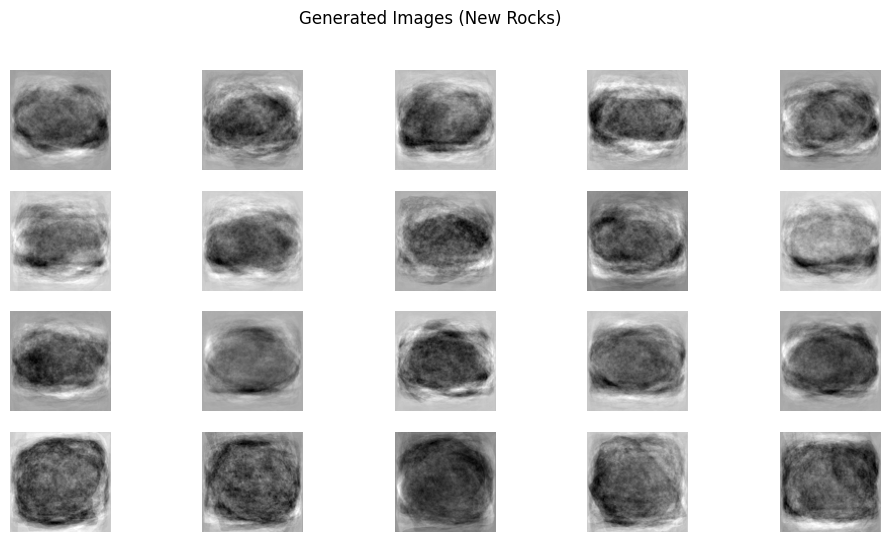

In [ ]:
# Generate new samples
samples, _ = gmm.sample(20)  # Generate 20 new samples
generated_images = pca_90.inverse_transform(samples)  # Reconstruct in original space

# Visualize generated images
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, img in enumerate(generated_images[:20]):  # Plot 10 images
    plt.subplot(4, 5, i + 1)
    plt.imshow(img.reshape(100,100), cmap='gray')  # Replace `image_shape` with the correct shape
    plt.axis('off')
plt.suptitle("Generated Images (New Rocks)")
plt.show()


In [ ]:
folder_path = '/content/drive/MyDrive/AI_ML_3/120 Rocks'
image_size = (100, 100)

# Load images and labels
images_val, labels_val = [], []
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img = Image.open(os.path.join(folder_path, filename)).convert('L')
        img = img.resize(image_size)
        images_val.append(np.array(img).flatten())
        labels_val.append(filename[0])

images_val = np.array(images_val)
labels_val = np.array(labels_val)

In [ ]:
images = images / 255.0  # Normalize pixel values to [0, 1]
images_val = images_val / 255.0

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial import procrustes

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),  # Last layer before softmax
    Dense(3, activation='softmax')  # 3 categories: 'I', 'M', 'S'
])


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Track training time
start_time = time.time()

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    images,
    validation_data=(images_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")


In [19]:
import numpy as np
from scipy.spatial import procrustes
from scipy.stats import pearsonr
from sklearn.decomposition import PCA # Import PCA
from sklearn.model_selection import train_test_split # Import train_test_split
# Step 7: Neural Network for Classification
# Prepare labels for neural network training
# Get the actual labels from the original 'labels' array (loaded previously)
labels_nn = np.array([0 if label == 'I' else 1 if label == 'M' else 2 for label in labels])

# One-hot encode the labels
labels_categorical = to_categorical(labels_nn, num_classes=3)

# Now perform train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(images, labels_categorical, test_size=0.25, random_state=42)  # Added random_state for reproducibility

# Neural network architecture
model = Sequential([
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=50, batch_size=32)
training_time = time.time() - start_time
print(f"Training time: {training_time} seconds")

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()

# Neural network parameter analysis
total_params = model.count_params()
bias_params = sum([np.prod(layer.get_weights()[1].shape) for layer in model.layers if len(layer.get_weights()) > 1])
print(f"Total parameters: {total_params}, Bias parameters: {bias_params}")

# Step 7d: Procrustes Analysis for Neural Network
# Compare human data with neural network embeddings
train_embeddings = model.predict(train_images)
val_embeddings = model.predict(val_images)
human_data_120 = np.loadtxt('/content/drive/MyDrive/AI_ML_3/mds_120.txt')

# Reduce human data to 3 dimensions using PCA
pca_human = PCA(n_components=3)
human_data_120_reduced = pca_human.fit_transform(human_data_120)

# Adjust the sample size to be less than or equal to the population size
sample_size = min(val_embeddings.shape[0], human_data_120_reduced.shape[0])

#Now, select the appropriate number of samples (rows)
#Match the sample size of the human data to the validation data (or vice-versa) by using a random sampling of rows
import random
random_indices = random.sample(range(train_embeddings.shape[0]), sample_size)
train_embeddings_sampled = train_embeddings[random_indices, :]

# Compute Procrustes Analysis and Correlation using reduced human data
train_disparity, train_correlations = compute_procrustes(human_data_120_reduced[:sample_size], train_embeddings_sampled) # Slice human data for matching size if needed

#For validation, do the same with the validation data
random_indices = random.sample(range(val_embeddings.shape[0]), sample_size)
val_embeddings_sampled = val_embeddings[random_indices, :]
val_disparity, val_correlations = compute_procrustes(human_data_120_reduced[:sample_size], val_embeddings_sampled) # Slice human data if needed

print("Neural Network Disparity and Correlations:")
print(f"Train - Disparity: {train_disparity}, Correlations: {train_correlations}")
print(f"Validation - Disparity: {val_disparity}, Correlations: {val_correlations}")


print("Neural Network Disparity and Correlations:")
print(f"Train - Disparity: {train_disparity}, Correlations: {train_correlations}")
print(f"Validation - Disparity: {val_disparity}, Correlations: {val_correlations}")

ValueError: Found input variables with inconsistent numbers of samples: [360, 3]